In [1]:
# Insert path to where you extract the mcgillthz folder to use the package anywhere
import sys 
sys.path.insert(1,"/Users/rodrigo/Programming/mcgillthz") 

from mcgillthz import *

# For iterative plots
# %matplotlib widget 

# For simple inline plots
%matplotlib inline 

This is a tutorial for the extraction of the optical reponse functions numerically using the functions contained in the "cookethz" package. Although a full documentation of the code is not available, the functions are thoroughly described where they are defined. The files that contain all the functions are:

- fft_utils.py - All Fourier transform related functions, including padding, wavelet transforms and more.
- import_utils.py - Functions to easily import experimental data, including error estimation and averaging.
- utils.py - Contains miscellaneous functions like a function to do Hilbert transform, calculate the Carrier Envelope phase (CEP) and to convert between response functions. Also includes physical constants
- tds_analysis.py - All functions needed for time-domain spectroscopy, from determining the amplitude and phase of the transmission coefficiet, to numerically find the complex refractive index.
- trts_analysis.py - All functions needed for time-resolved THz spectroscopy, from determining the amplitude and phase of the transmission coefficiet, to numerically find the complex conductivity for all time-delays.
- basic_plots.py - Basic functions to do standard plots quickly.

# Silicon

## Import files

Let's import the files without any parameters and plot them.

We'll use the import_file( ) function. If multiple averages were taken, import_files( ) could be used instead to give an error estimate.

/Users/rodrigo/anaconda3/envs/PHYS/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rodrigo/anaconda3/envs/PHYS/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


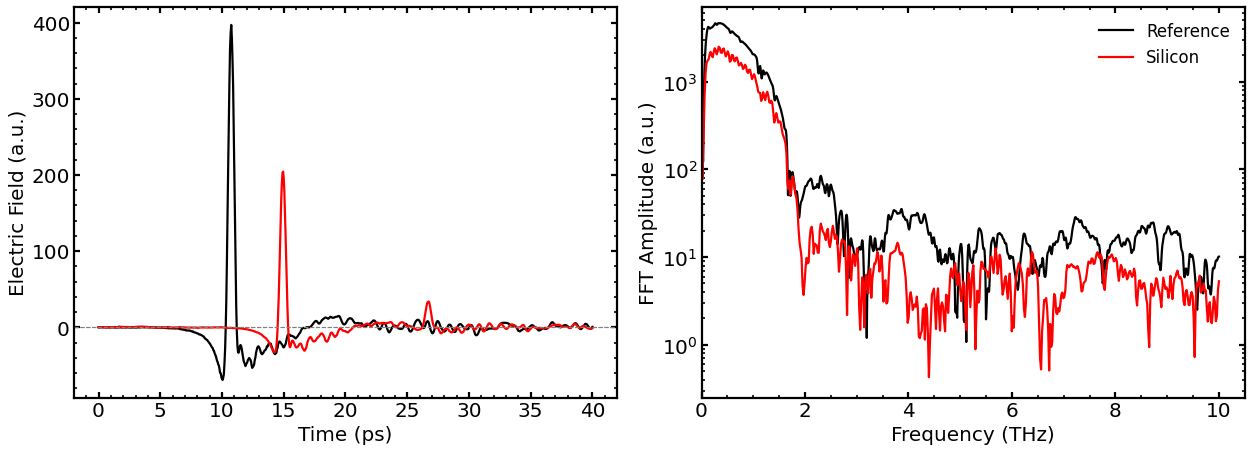

In [2]:

file = './data/Silicon-ref.DAT'
ref_td, ref_fft = import_file(file)

file = './data/Silicon.DAT'
si_td, si_fft = import_file(file)

axs = plot_spectrum(ref_td, ref_fft, color='black', label='Reference')
axs = plot_spectrum(si_td, si_fft, color='red', label='Silicon', axs=axs)


Now we can re-import them, setting the appropriate parameters. 

max_time=25 removes the Fabry-Perot reflection. Taking the reflections into account is possible when defining the transfer function, but requires very precise determination of the sample thickness. 

max_t_bg=5 will consider that everything before 5 ps is experimental background, and will subtract that value.

You can also choose another type of FFT window. Examples that work well are "hann", "blackman", "hamming" or "nuttall" etc.

The max_freq parameter in plot_spectrum sets the frequency at which to start calculating the RMS background, plot as a horizontal solid line.

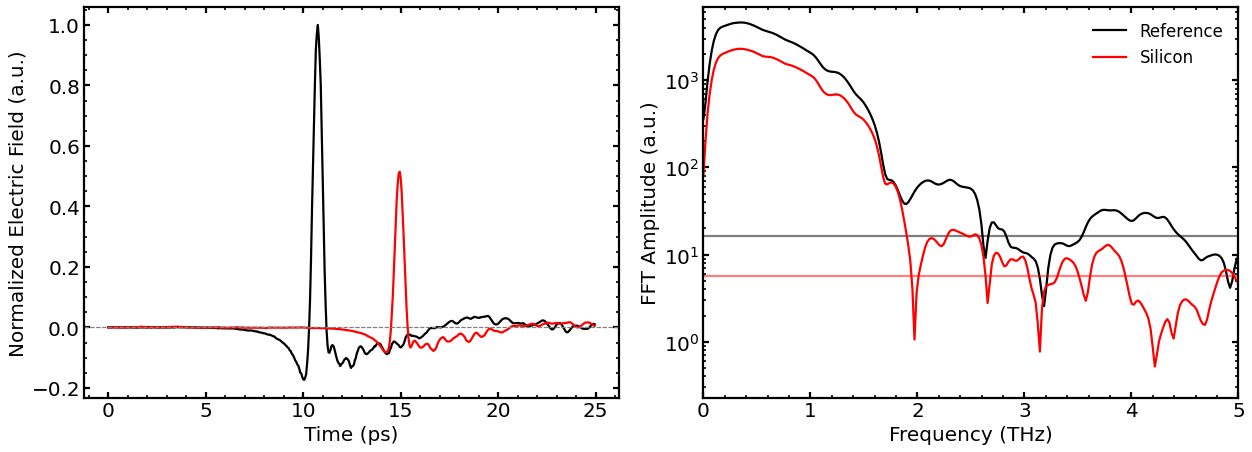

In [3]:

file = './data/Silicon-ref.DAT'
ref_td, ref_fft = import_file(file, normalize=1, max_time=25, max_t_bg=5, window='nuttall')

file = './data/Silicon.DAT'
si_td, si_fft = import_file(file, normalize=1, max_time=25, max_t_bg=10, window='nuttall')

axs, norm = plot_spectrum(ref_td, ref_fft, color='black', label='Reference', normalize=0, max_freq=3)
axs = plot_spectrum(si_td, si_fft, color='red', label='Silicon', axs=axs, normalize=norm, max_freq=3)

axs[1].set_xlim(0, 5)

plt.show()

- It is important that both the sample and reference data have the same number of data points and time-resolution. Otherwise, the phase extraction on the transmission fails.

That's why we set max_time=25 on the reference data too. Alternatively, you can use the parameter "pad_td = N" on import_file() to pad the time domain on the right-hand side with 0s, compensating for the removed data points.

- The Fourier transform also must have the same number of data points. 

You can check both conditions below.

In [4]:
print('Same number of points in time-domain: '+str(len(si_td[0]) == len(ref_td[0])))
print('Same frequencies: '+str(len(si_fft[0]) == len(ref_fft[0])))


Same number of points in time-domain: True
Same frequencies: True


## Get transmission

We use the get_T_tds() function to calculate the transmission amplitude and phase. The phase unwrapping is performed as described in Peter Jepsen's "Phase Retrieval in THz Time-Domain Measurements: a how to Tutorial".

The freqs_for_fit has to be set in a frequency range without many absorptions. A line will be fitted in this region to subtract any offsets multiple of 2 $\pi$.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


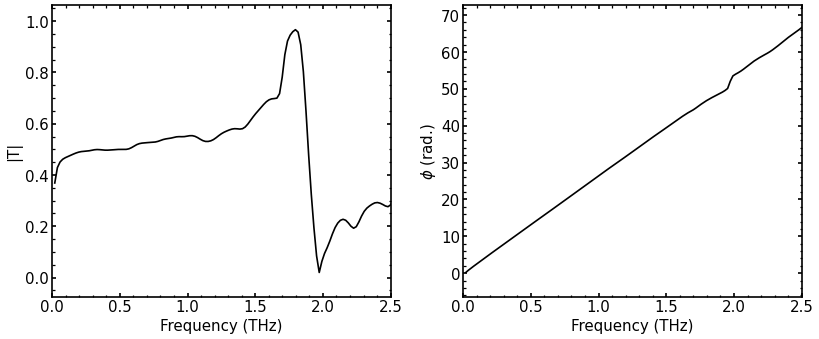

In [5]:
T_Si = get_T_tds(ref_td, ref_fft, si_td, si_fft, freqs_for_fit=[0.4, 1])


axs = plot_transmission(T_Si)
axs[0].set_xlim(0, 2.5)
autoscale_y(axs[0])
autoscale_y(axs[1])


We can plot it without the offset from the time displacement. For that, you need the time-delay between the reference and the sample peaks. The phase should be close to 0 without absorptions.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


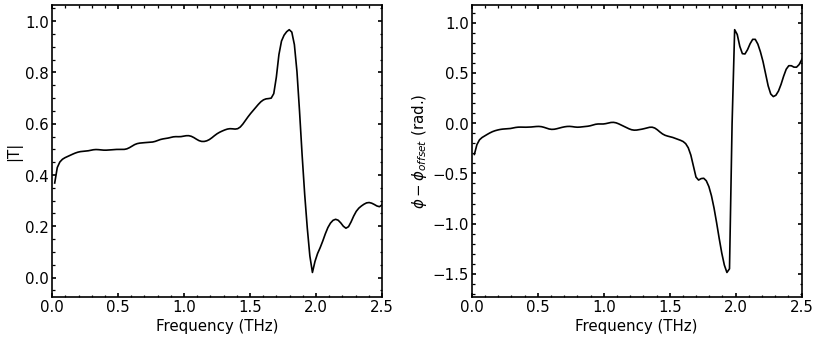

In [6]:

delta_t = si_td[0][np.argmax(si_td[1])] - ref_td[0][np.argmax(ref_td[1])]

axs = plot_transmission(T_Si, delta_t=delta_t)

axs[0].set_xlim(0, 2.5)
autoscale_y(axs[0])
autoscale_y(axs[1])

## Define the transmission function

This experiment was performed as follows

$$\text{Reference: } E_{in} \Rightarrow \text{air}(d) \Rightarrow E_{ref}$$


$$\text{Sample: } E_{in} \Rightarrow \text{Si}(d) \Rightarrow E_{samp}$$

This means we can write

$$ E_{ref} = P_{n_0} (d) E_{in} $$

$$ E_{samp} = t_{n_0, \tilde{n}} P_{\tilde{n}}(d) t_{\tilde{n}, n_0} E_{in} $$

Here, $n_0$ is the refractive index of the air and $\tilde{n}$ is the refractice index of the sample, that we want to find out. The complex Fresnel coefficient for the transmission of an electric field normal to a surface $t_{n_1, n_2}$ is

$$ t_{n_1, n_2} = \frac{2 n_1}{n_1 + n_2} $$

, and $P_{n_1}(d)$ represents the propagation of plane wave within a material of index $n$ for a distance $d$, represented as

$$ P_{n_1}(d) = e^{i \omega d n_1 / c} .$$

The transmission function, in this case, is simply

$$ T = \frac{E_{samp}}{E_{ref}} = \frac{t_{n_0, \tilde{n}} P_{\tilde{n}}(d) t_{\tilde{n}, n_0} }{P_{n_0}(d)}$$


When you define it, the function must have the complex refractive index to be found as the first parameter, the frequency as the second, and as many fixed parameters as needed afterwards.

The function must return the amplitude, and the phase separately.


In [7]:
def T_function(n_til, freq, d, n0):
    """
    n_til will be the fitted parameter, so it is the unknown refractive index
    freq must be the second parameter, the frequencies in THz
    d, nd are fixed paremeters specific to this experiment

    The function must return the amplitude and phase separatelly, but any transfer function can be used.
    """
    k = 2*np.pi*(freq * 1e12)/c # Defines the vacuum wavenumber in Si units

    t01 = 2 * n0 / (n_til + n0)
    P1 = np.exp(1j * k * d * n_til)
    t10 = 2 * n_til / (n_til + n0)

    P2 = np.exp(1j * k * d * n0)

    amp = np.abs(t01 * P1 * t10 / P2 )  # np.abs( ) get's the absolute value
    # np.angle( ) returns the phase of a complex number between -2pi and +2pi, so we add then individually. 
    # We calculate the phase from propagating terms manually to avoid the limits of np.angle() as well.
    phase = np.angle(t01) + np.angle(t10) + (k*d*np.real(n_til)) - (k*d*np.real(n0))    

    return amp, phase

## Fit the transmission

Now we define the frequencies at which to calculate the refractive index, give an initial guess, and call the function minimize_err( ) to find the complex refractive index.

Make sure the frequencies you select include only regions where you have a decent THz amplitude.

The minimize_err_tds() function does the numerical extraction of the refractive index. It uses the scipy.minimize function, and the method used can be selected using the "method" parameter. Typical methods include "L-BFGS-B", "Powell" or "Nelder-Mead", where the last two take longer to optimize but work better when absorptive features are present.

Another important parameter of minimize_err_tds() is "start_from". Setting "start_from" to "low" will fit the lowest frequency first, and then increase the frequency one by one, using the previous frequency as the initial guess. "start_from = high" does the same, but starting from the highest frequency instead. Both these methods require setting the parameter "n_til0" as an initial guess for the refractive index.



In [8]:
n0 = 1
d_Si = 520e-6

freqs_Si = np.arange(.05, 1.7, .01)

n_guess = 3 + 1j * 1e-3

n_Si = minimize_err_tds(freqs_Si, T_function, [d_Si, n0], T_Si[0], T_Si[1], T_Si[2], method='L-BFGS-B', start_from='low', n_til0=n_guess)



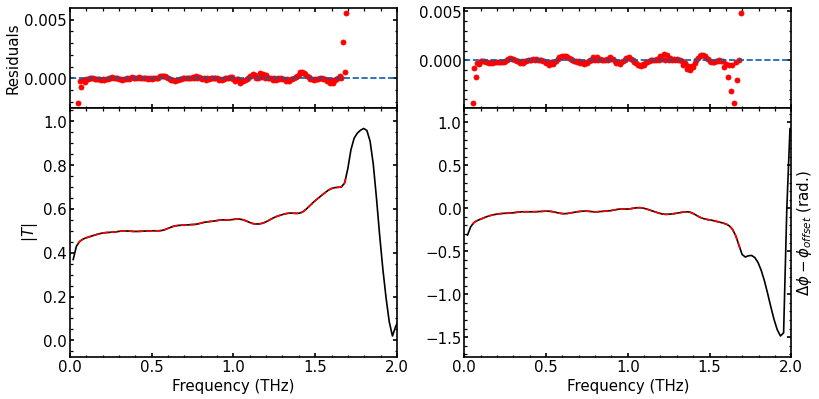

In [9]:
delta_t = si_td[0][np.argmax(si_td[1])] - ref_td[0][np.argmax(ref_td[1])]

Amp, phase = T_function(n_Si, freqs_Si, d_Si, n0)

axs = plot_transmission_fit(T_Si[0], T_Si[1], T_Si[2], freqs_Si, Amp, phase, delta_t=delta_t, xlim=[0, 2])

Alternativelly, you can use "start_from = simple", where it will use the approximation of low absorption and no substrate to give an initial guess of the refractive index. In this case, it is required to give the thickness of the sample through the parameter "d".

In [10]:
n0 = 1
d_Si = 520e-6

freqs_Si = np.arange(.05, 1.7, .01)


n_Si = minimize_err_tds(freqs_Si, T_function, [d_Si, n0], T_Si[0], T_Si[1], T_Si[2], method='Powell', start_from='simple', d=d_Si)

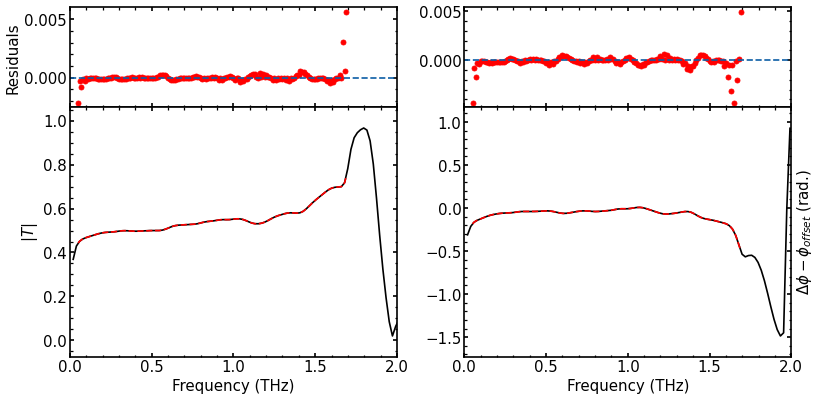

In [11]:
delta_t = si_td[0][np.argmax(si_td[1])] - ref_td[0][np.argmax(ref_td[1])]

Amp, phase = T_function(n_Si, freqs_Si, d_Si, n0)

axs = plot_transmission_fit(T_Si[0], T_Si[1], T_Si[2], freqs_Si, Amp, phase, delta_t=delta_t, xlim=[0, 2])

If the model lines match the experimental lines, and the residuals are considerably smaller that the actual values, we have a succesfull fit! If not, try changing the optimization method, the frequency range (sometimes a finer grid is needed when there is absorption), or start the fit from low frequencies first (set start_from_low=True)

## Plot response functions

The plot_n_til() readily plots the complex refractive index. The absorb=True tag transforms the extinction coefficient $\kappa$ into the absorption coefficient in (cm-1)

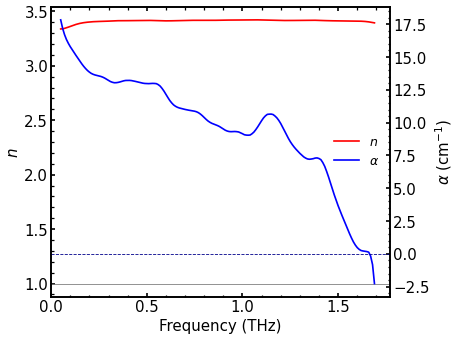

In [12]:
ax = plot_n_til(freqs_Si, n_Si, absorb=True)

We can calculate the dielectric constant and the conductivity easily.

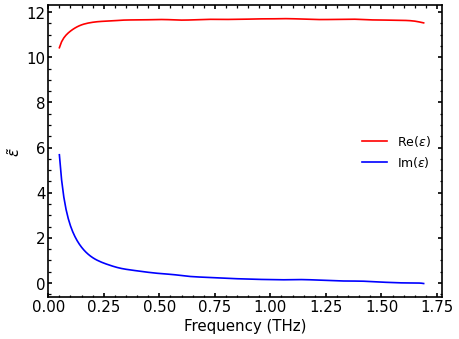

In [13]:
eps_Si = eps_from_n(n_Si)

ax = plot_eps(freqs_Si, eps_Si)

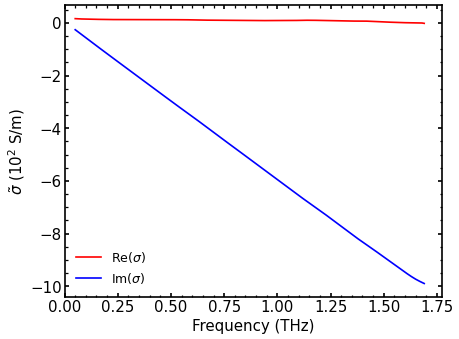

In [14]:
sig_Si = sig_from_n(n_Si, freqs_Si)

ax = plot_sigma(freqs_Si, sig_Si, norm=1e2)

# Lactose

Now let's do the same with lactose. Lactose has very strong THz absorption, so the fit is significantly harder.

## Import files

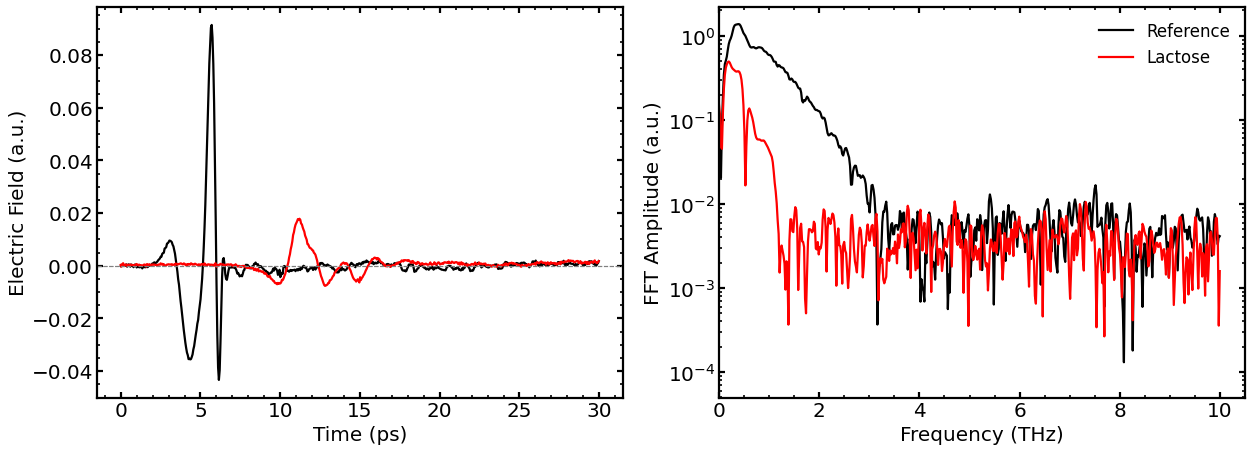

In [15]:
file = './data/Lactose-Ref.DAT'
ref_td, ref_fft = import_file(file)

file = './data/Lactose.DAT'
lac_td, lac_fft = import_file(file)

axs = plot_spectrum(ref_td, ref_fft, color='black', label='Reference')
axs = plot_spectrum(lac_td, lac_fft, color='red', label='Lactose', axs=axs)


(0.0, 4.0)

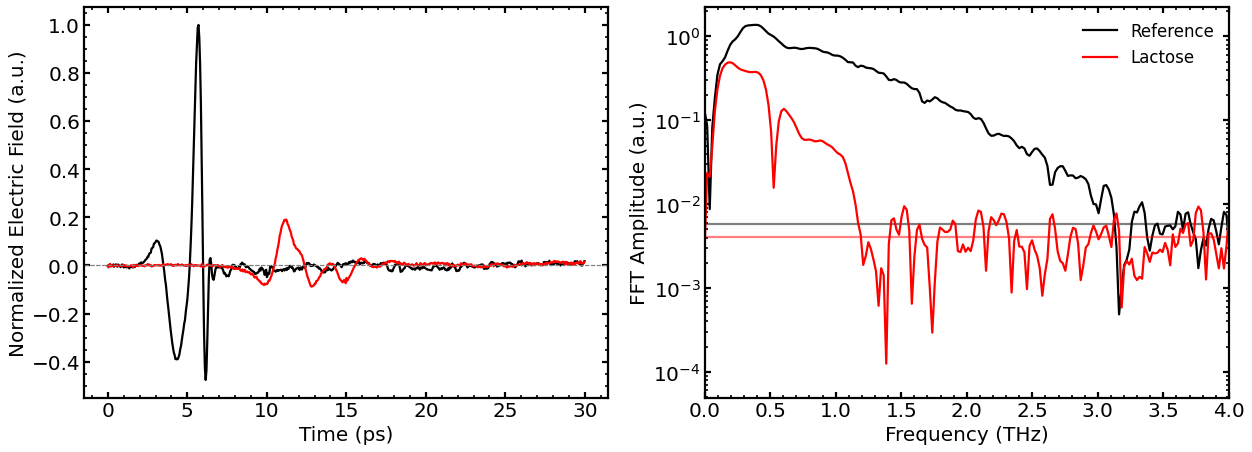

In [16]:
file = './data/Lactose-Ref.DAT'
ref_td, ref_fft = import_file(file, max_t_bg=0.6)

file = './data/Lactose.DAT'
lac_td, lac_fft = import_file(file, max_t_bg=5)

axs, norm = plot_spectrum(ref_td, ref_fft, color='black', label='Reference', normalize=0, max_freq=4)
axs = plot_spectrum(lac_td, lac_fft, color='red', label='Lactose', axs=axs, normalize=norm, max_freq=4)

axs[1].set_xlim(right=4)


## Get transmission

Here, care must be taken in selecting the freqs_for_fit range. Don't choose a region with absorptive features.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 4.0)

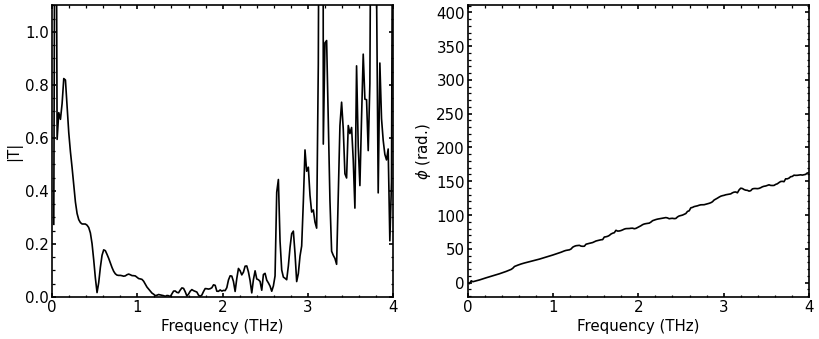

In [17]:
T_lac = get_T_tds(ref_td, ref_fft, lac_td, lac_fft, freqs_for_fit=[0.1, .3])


axs = plot_transmission(T_lac)

axs[0].set_xlim(0,4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-10.0, 10.0)

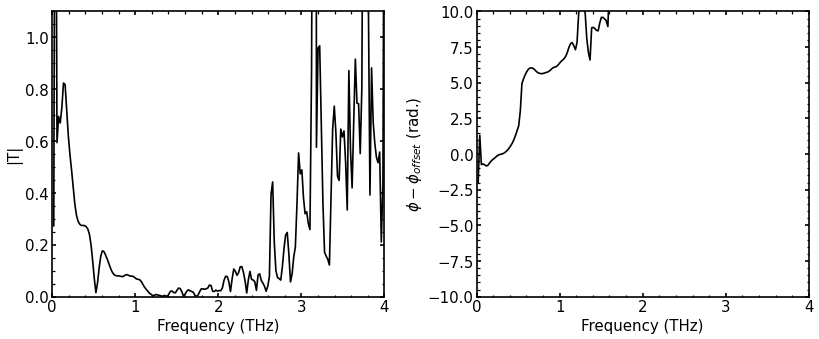

In [21]:


delta_t = lac_td[0][np.argmax(lac_td[1])] - ref_td[0][np.argmax(ref_td[1])]

axs = plot_transmission(T_lac, delta_t=delta_t)

axs[0].set_xlim(0,4)
axs[1].set_ylim(-10, 10)


## Define transmission function

This experiment is the same as the previous one. Either going through the sample or going through air.

In [22]:
def T_function(n_til, freq, d, n0):
    """
    n_til will be the fitted parameter, so it is the unknown refractive index
    freq must be the second parameter, the frequencies in THz
    d, nd are fixed paremeters specific to this experiment

    The function must return the amplitude and phase separatelly, but any transfer function can be used.
    """
    k = 2*np.pi*(freq * 1e12)/c # Defines the vacuum wavenumber in Si units

    t01 = 2 * n0 / (n_til + n0)
    P1 = np.exp(1j * k * d * n_til)
    t10 = 2 * n_til / (n_til + n0)

    P2 = np.exp(1j * k * d * n0)

    amp = np.abs(t01 * P1 * t10 / P2 )  # np.abs( ) get's the absolute value
    # np.angle( ) returns the phase of a complex number between -2pi and +2pi, so we add then individually. 
    # We calculate the phase from propagating terms manually to avoid the limits of np.angle() as well.
    phase = np.angle(t01) + np.angle(t10) + (k*d*np.real(n_til)) - (k*d*np.real(n0))    

    return amp, phase

## Fit transmission

Due to sharp absorptions, the frequency spacing must be reduced to acquire a good fit. In fact, the refractive index extraction is no longer significant once you've hit the noise floor. See Jepsen (doi 10.1364/OL.30.000029) for detailed discussion.

In this experiment, the transmission goes to zero close to 1.3 THz.

In [24]:
n0 = 1
d_lac = 2e-3

freqs_lac = np.arange(.05, 1.3, .01)

n_guess = 1 + 0j * 1

n_lac = minimize_err_tds(freqs_lac, T_function, [d_lac, n0], T_lac[0], T_lac[1], T_lac[2], method='Nelder-Mead', start_from='low', n_til0=n_guess)


Using n = 1 as initial guess. If optimization fails, please insert an initial guess for variable "n_til0".


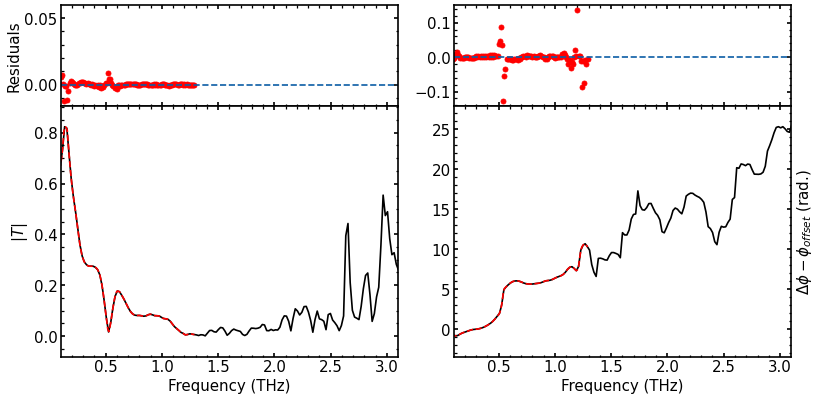

In [25]:


delta_t = lac_td[0][np.argmax(lac_td[1])] - ref_td[0][np.argmax(ref_td[1])]

Amp, phase = T_function(n_lac, freqs_lac, d_lac, n0)

fig, axs = plot_transmission_fit(T_lac[0], T_lac[1], T_lac[2], freqs_lac, Amp, phase, delta_t=delta_t, xlim=[0.1, 3.1])


## Plot response functions

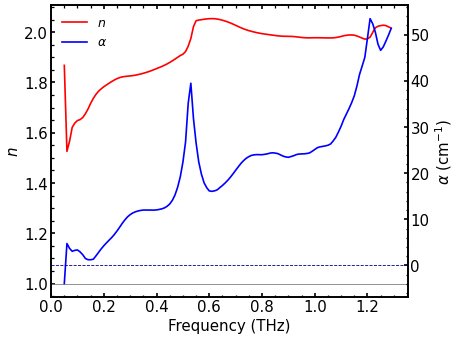

In [26]:
ax = plot_n_til(freqs_lac, n_lac, absorb=True)

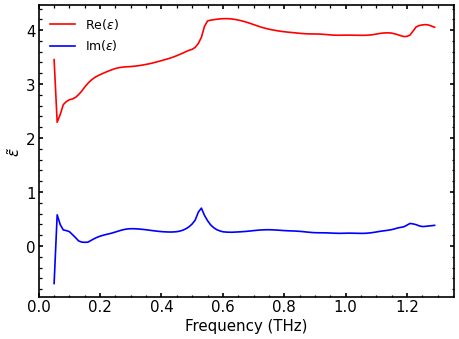

In [27]:
eps_lac = eps_from_n(n_lac)

ax = plot_eps(freqs_lac, eps_lac)

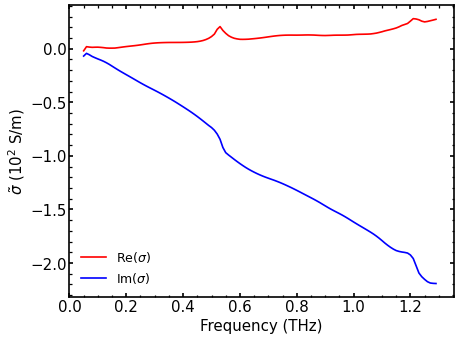

In [28]:
sig_lac = sig_from_n(n_lac, freqs_lac)

ax = plot_sigma(freqs_lac, sig_lac, norm=1e2)